In [1]:
import keras
from keras.models import model_from_json

from universal_datagen.generator.generator_text import AM2018TxtGenerator
from universal_models.models.rnn import *
from universal_models.losses.losses import *

from utils import *

import os
import glob
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
structure = 'sequence'

stack_size = 5
input_height = 448
input_width = 448
input_channels = 1

input_dim = (input_height, input_width, input_channels)

num_classes = 4

labeled=True
if labeled:
    output_channels = num_classes
else:
    output_channels = 1

In [3]:
# Create model
model, output_height, output_width = lstm_unet(input_height, input_width, input_channels, num_classes, filters=16)
model.summary(line_length=120)

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   (None, None, 448, 448, 1)  0                                                     
________________________________________________________________________________________________________________________
time_distributed_1 (TimeDistributed)   (None, None, 448, 448, 16) 160           input_1[0][0]                           
________________________________________________________________________________________________________________________
time_distributed_2 (TimeDistributed)   (None, None, 448, 448, 16) 64            time_distributed_1[0][0]                
________________________________________________________________________________________________________________________
time_distributed_3 (TimeDistribu

In [7]:
batch_size = estimate_batchsize(model, 16000, timesteps=stack_size)
print("estimated", batch_size)

batch_size = 4

estimated 10.291383410971891


In [10]:
data_dirs = glob.glob('/l/projects/data/AM2018_SIMULATION/1200/*') + glob.glob('/l/projects/data/AM2018_SIMULATION/2700/*')
print("data_dirs", len(data_dirs))

crop_area = 0.8 # 60% of image ish
crop_scale = np.round((input_height/crop_area)/1600, 2)
print("crop_scale", crop_scale)

num_seq = 10
print("num_sequences", num_seq)
training_data = AM2018TxtGenerator(data_dirs, (input_height, input_width, stack_size),
                                   (output_height, output_width, num_classes),
                                   num_data=len(data_dirs) * stack_size * num_seq)
print("data_len", len(training_data))

split = 0.1
tgen, vgen = training_data.generator(structure=structure, labeled=labeled, batch_size=batch_size, split=split)

tsteps = int((1 - split) * len(training_data) / batch_size)
vsteps = int(split * len(training_data) / batch_size)

data_dirs 10
crop_scale 0.25
num_sequences 10
data_len 100


In [11]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss=ce_dice_loss, metrics=[gen_dice_coeff])
#model.fit(x, y, epochs=300, batch_size=8)
model.fit_generator(tgen, steps_per_epoch=tsteps, epochs=50, validation_data=vgen, validation_steps=vsteps)

Epoch 1/50
22/22 [==============================] - 111s 5s/step - loss: 1.7200 - gen_dice_coeff: 0.0613 - val_loss: 2.1296 - val_gen_dice_coeff: 0.0782
Epoch 2/50
22/22 [==============================] - 96s 4s/step - loss: 1.2951 - gen_dice_coeff: 0.1445 - val_loss: 1.3098 - val_gen_dice_coeff: 0.0814
Epoch 3/50
22/22 [==============================] - 96s 4s/step - loss: 0.9712 - gen_dice_coeff: 0.3273 - val_loss: 1.1055 - val_gen_dice_coeff: 0.1651
Epoch 4/50
22/22 [==============================] - 96s 4s/step - loss: 0.7185 - gen_dice_coeff: 0.5555 - val_loss: 1.1129 - val_gen_dice_coeff: 0.2751
Epoch 5/50
22/22 [==============================] - 96s 4s/step - loss: 0.6235 - gen_dice_coeff: 0.6071 - val_loss: 1.0461 - val_gen_dice_coeff: 0.2234
Epoch 6/50
22/22 [==============================] - 97s 4s/step - loss: 0.5653 - gen_dice_coeff: 0.6373 - val_loss: 1.0764 - val_gen_dice_coeff: 0.2289
Epoch 7/50
22/22 [==============================] - 98s 4s/step - loss: 0.5343 - gen_di

In [18]:
eval_data = AM2018TxtGenerator(data_dirs[-3:-2],
                               (input_height, input_width, 1),
                               (output_height, output_width, num_classes),
                               crop_scale=crop_scale)

data = eval_data.iterator(structure='pair', labeled=labeled, cropped=True)

len_sequence = 20
xb, yb = [], []
for i in range(len_sequence):
    x, y = next(data)
    xb.append(x)
    yb.append(y)

xb = np.asarray(xb)
yb = np.asarray(yb)

print(xb.shape, yb.shape)

(20, 320, 320, 1) (20, 320, 320, 4)


# Prepare Network for Statefulness

In [13]:
weights = []
for l in model.layers:
    weights.append(l.get_weights())

In [15]:
# Replace input layer with one that has batchsize 
new_model, _, _ = lstm_shallow(input_height, input_width, input_channels, num_classes, stateful=True, timesteps=1, batchsize=1)
for i, w in enumerate(weights):
    new_model.layers[i].set_weights(w)

# Feed one image at a time and compare to target

In [19]:
# Reset states
new_model.reset_states()

# Feed output back as input
len_sequence = 15

o = []
for i in range(len_sequence):
    x = xb[np.newaxis, i:i+1, ...]
    p = new_model.predict(x)
    o.append(p)

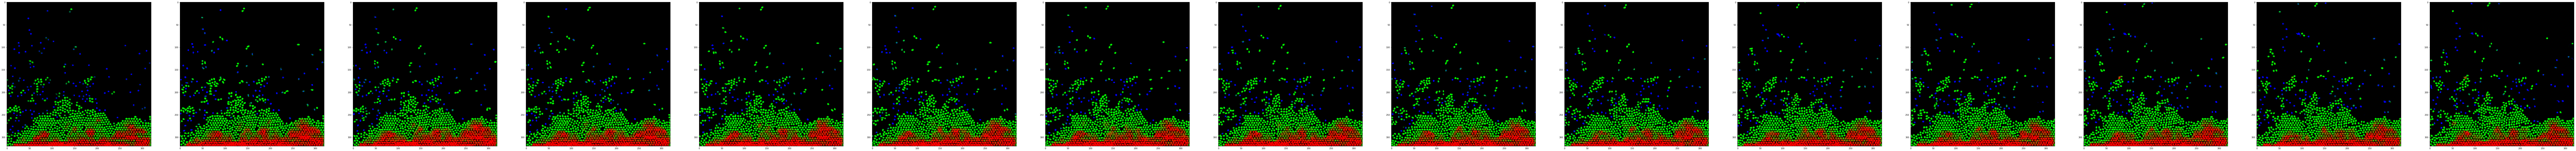

In [20]:
output = np.squeeze(o)

ncols = len(output)
nrows =  1
plt.figure(figsize=(15 * ncols, 15 * nrows))
for i in range(len(output)):
    plt.subplot(nrows, ncols, i + 1)
    if yb.shape[-1] == 1:
        plt.imshow(output[i], cmap='gray', interpolation='none')
        plt.imshow(yb[i, ..., 0], cmap='jet', interpolation='none', alpha=0.3)
    else:        
        plt.imshow(output[i, ..., 1:], cmap='gray', interpolation='none')
        #plt.imshow(yb[i, ..., 1:] * 255, cmap='jet', interpolation='none', alpha=0.3)